In [2]:
# install our packages
library(dplyr)
library(boot)
library(pscl)
library(MASS)
library(ggplot2)
library(ggpubr)
library(lme4)
library(AER)
library(cowplot)

# # setwd()
# this.dir <- dirname(parent.frame(2)$ofile)
# setwd(this.dir)

In [22]:
rnai_spore_data <- read.csv("gene_silencing_spores.csv")
str(rnai_spore_data)

'data.frame':	180 obs. of  8 variables:
 $ bee_code      : chr  "Hive1_Con.Scram_1" "Hive1_Con.Scram_2" "Hive1_Con.Scram_3" "Hive1_Con.Scram_4" ...
 $ treatment     : chr  "Con.Scram" "Con.Scram" "Con.Scram" "Con.Scram" ...
 $ infection     : chr  "Non-Infected" "Non-Infected" "Non-Infected" "Non-Infected" ...
 $ rnai          : chr  "Scram" "Scram" "Scram" "Scram" ...
 $ hive          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ susceptibility: int  1 0 1 0 0 1 0 0 0 0 ...
 $ spores        : int  5600000 0 1600000 0 0 3200000 0 0 0 0 ...
 $ divided_100000: int  56 0 16 0 0 32 0 0 0 0 ...


In [23]:
rnai_spore_data$hive <- factor(rnai_spore_data$hive)
rnai_spore_data$infection <- factor(rnai_spore_data$infection)
rnai_spore_data$rnai <- factor(rnai_spore_data$rnai)
head(rnai_spore_data)

,bee_code,treatment,infection,rnai,hive,susceptibility,spores,divided_100000
,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<int>,<int>
1,Hive1_Con.Scram_1,Con.Scram,Non-Infected,Scram,1,1,5600000,56
2,Hive1_Con.Scram_2,Con.Scram,Non-Infected,Scram,1,0,0,0
3,Hive1_Con.Scram_3,Con.Scram,Non-Infected,Scram,1,1,1600000,16
4,Hive1_Con.Scram_4,Con.Scram,Non-Infected,Scram,1,0,0,0
5,Hive1_Con.Scram_5,Con.Scram,Non-Infected,Scram,1,0,0,0
6,Hive1_Con.Scram_6,Con.Scram,Non-Infected,Scram,1,1,3200000,32


## 1. Inspect the data structure

### 1a. Infection susceptibility

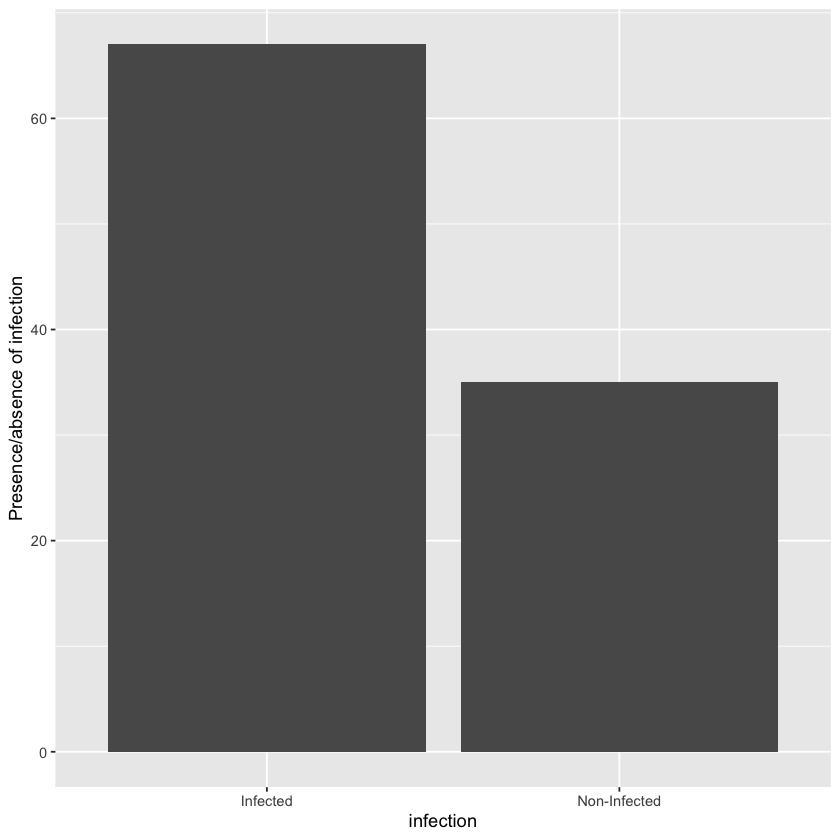

In [24]:
rnai.infection.susceptibility.bar <- ggplot(data = rnai_spore_data, aes(x=infection, y=susceptibility)) + 
geom_bar(stat = "identity") + ylab("Presence/absence of infection")
rnai.infection.susceptibility.bar
# presence/absence of spores is not completely explained by infection. Not all 90 infected bees tested 
# positive for spores, and not all control tested negative

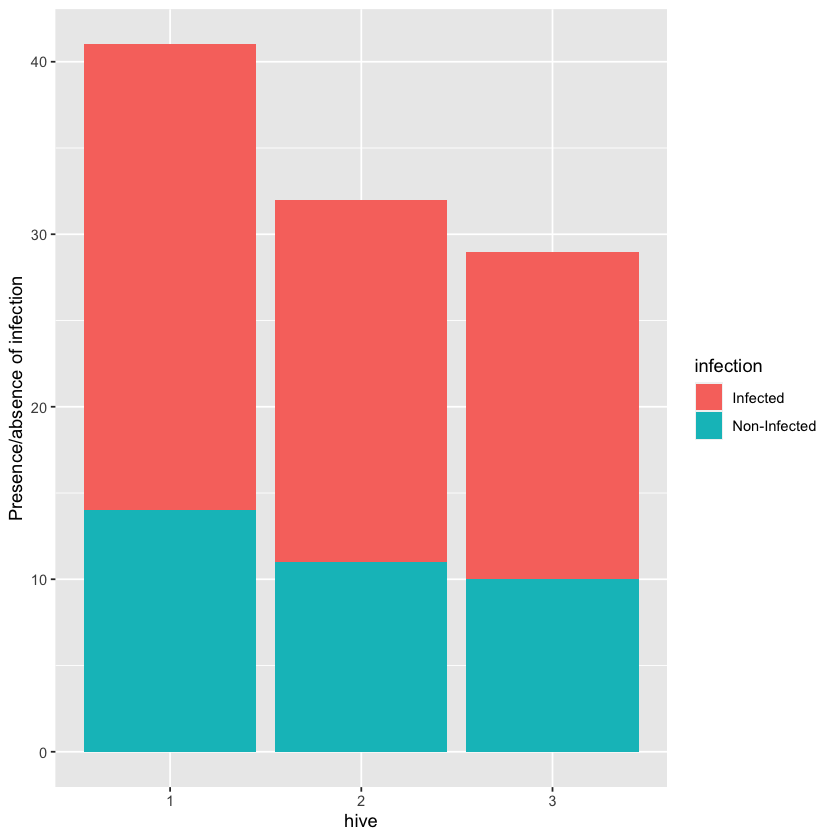

In [25]:
rnai.infection.hive.suscetibility.barplot <- ggplot(data = rnai_spore_data, aes(x=hive, y=susceptibility, fill = infection)) + 
geom_bar(stat = "identity") + ylab("Presence/absence of infection")
rnai.infection.hive.suscetibility.barplot
# Hive 1 appeared to have a higher level of infection, with 40/60 bees showing spores. Hive 2 is higher than
# hive 3, so could well be a hive effect

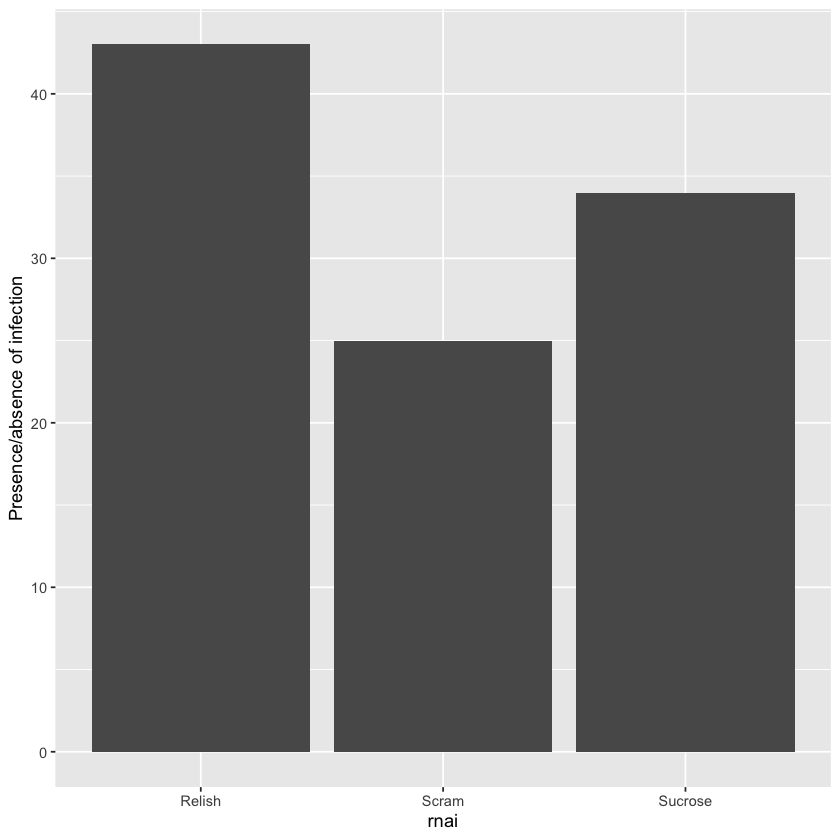

In [26]:
rnai.susceptibility.barplot <- ggplot(data = rnai_spore_data, aes(x=rnai, y=susceptibility)) + 
geom_bar(stat = "identity") + ylab("Presence/absence of infection")
rnai.susceptibility.barplot
# shows that more bees were infected when treated with Relish RNAi (absence of Relish), this is interesting
# as means Relish could be important for preventing infection

### 1b. Spore counts

0,0,0
0,0,0
24,0,12
40,32,44
96,72,104
15.84092,-6.527268,3.025007
32.15908,6.527268,20.974993


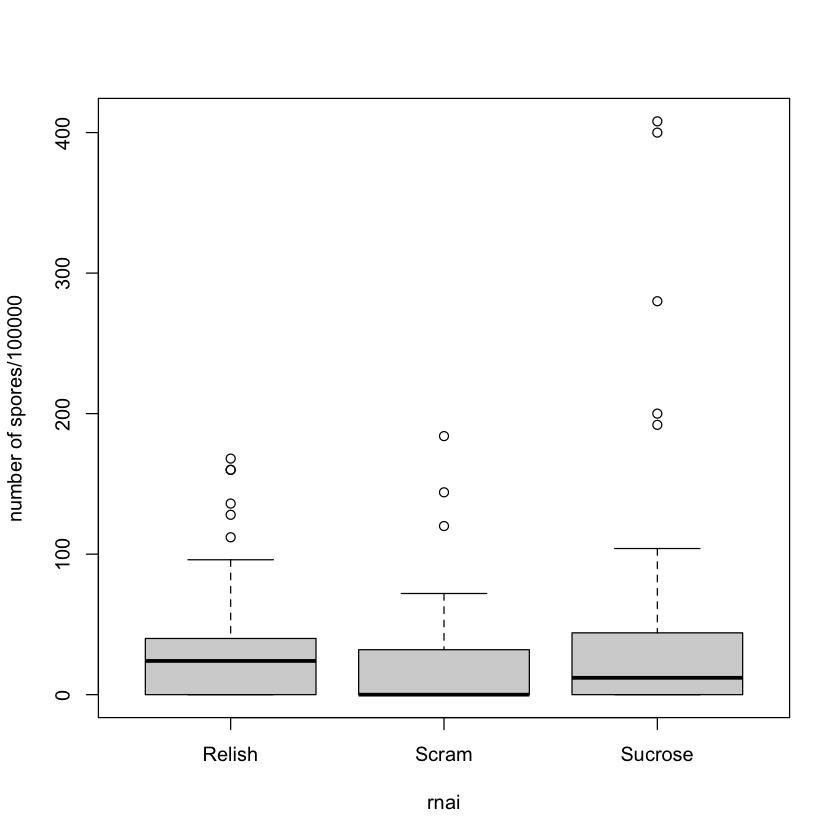

In [29]:
rnai.spores.boxplot <- boxplot(divided_100000 ~ rnai, data = rnai_spore_data, ylab = "number of spores/100000")
rnai.spores.boxplot
# doesnt look like a huge difference between them, but all of these contain controls where there are lots of
# zeros. Although even still, upper bounds of treatments are all very similar which we wouldnt expect if 
# there was a signficant difference

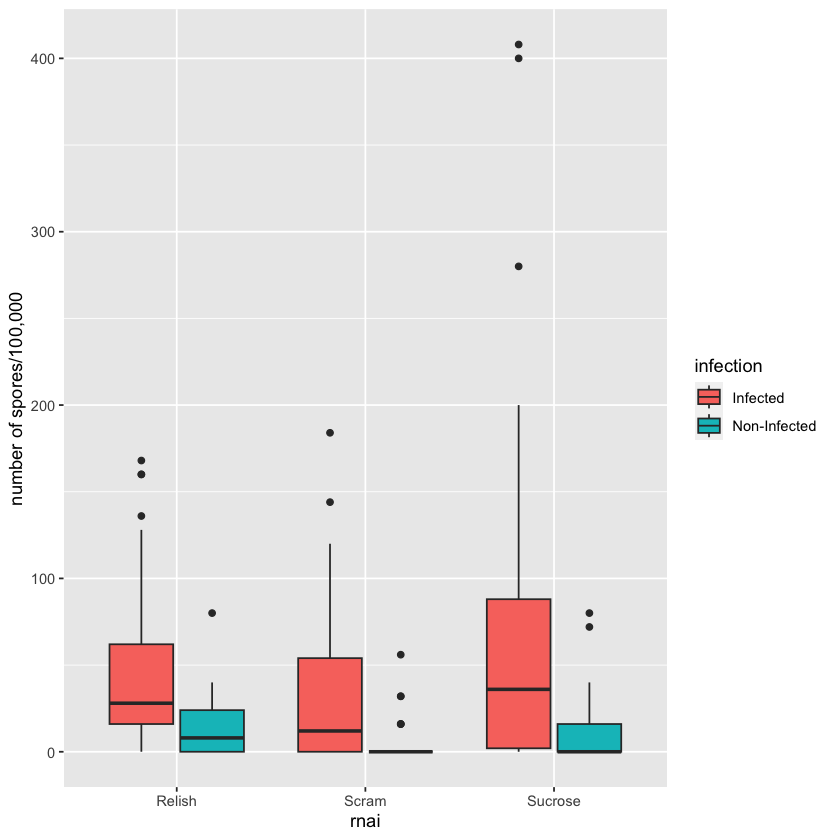

In [31]:
rnai.by.infection.spores.boxplot <- ggplot(data = rnai_spore_data, aes(x=rnai, y=divided_100000, fill=infection)) +
                                            geom_boxplot() + ylab("number of spores/100,000")
rnai.by.infection.spores.boxplot
# not a massive difference between treatments that I can see, spore number seem pretty similar

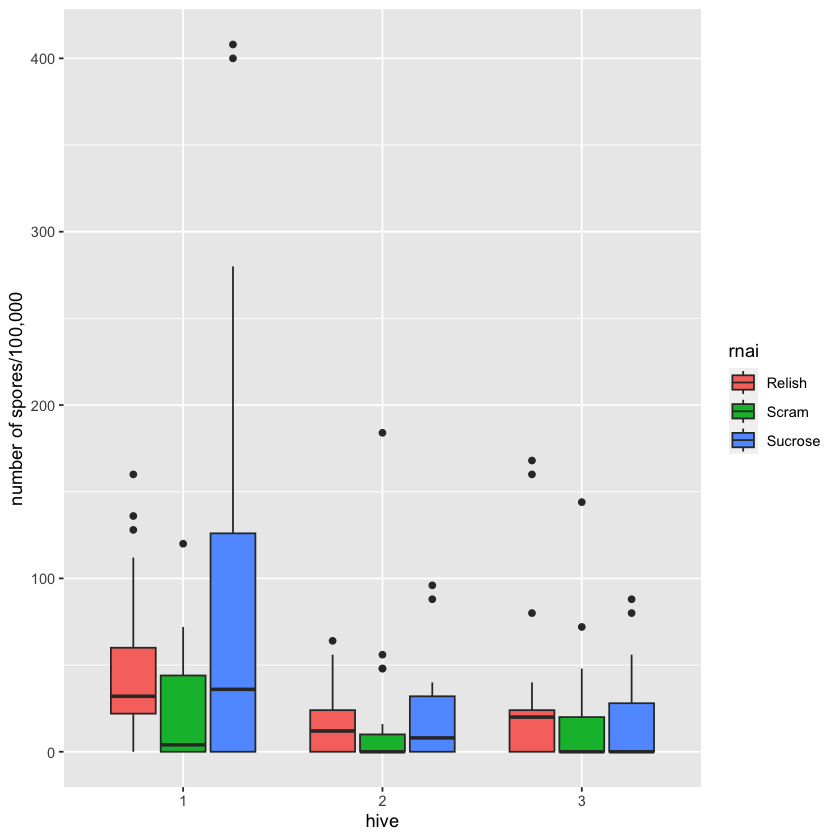

In [32]:
rnai.by.hive.boxplot <- ggplot(data = rnai_spore_data, aes(x=hive, y=divided_100000, fill=rnai)) + geom_boxplot() + ylab("number of spores/100,000")
rnai.by.hive.boxplot
# hive 1 appears to have much higher spores than the others, which is strange because it was hive 3 that had the 
# lowest survival. In fact, other hives have low spores compared to hive 1 in  all treatments. So definite
# potential hive effect there

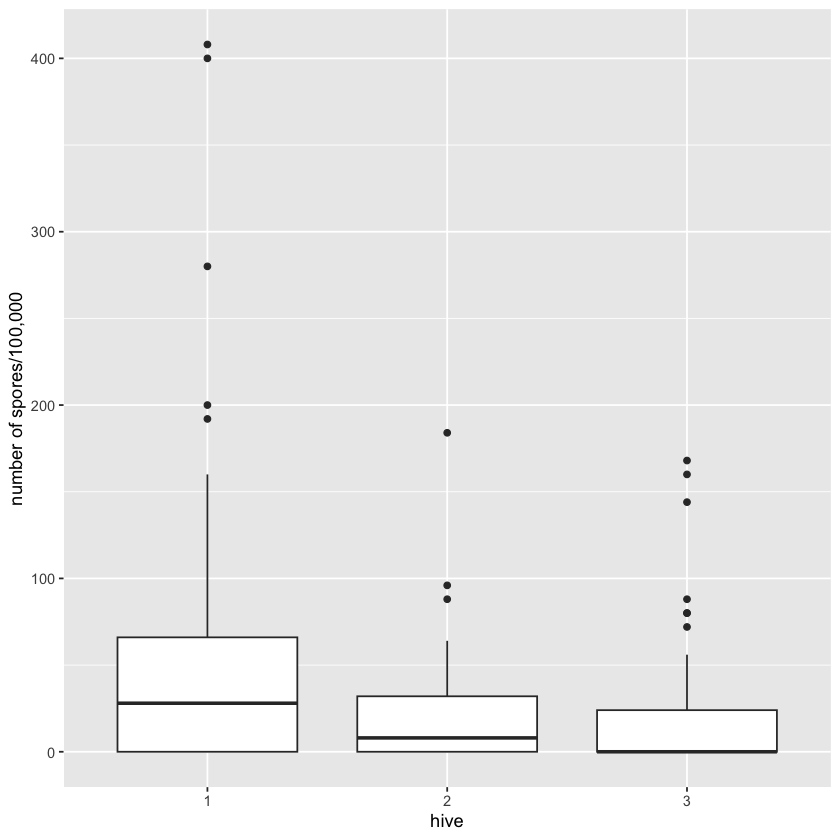

In [35]:
hive.boxplot <- ggplot(data = rnai_spore_data, aes(x=hive, y=divided_100000)) + geom_boxplot() + ylab("number of spores/100,000")
hive.boxplot
# hive 1 appears to be a lot higher than the others, we will have to test for a significant random effect

## 2. Selecting a Model

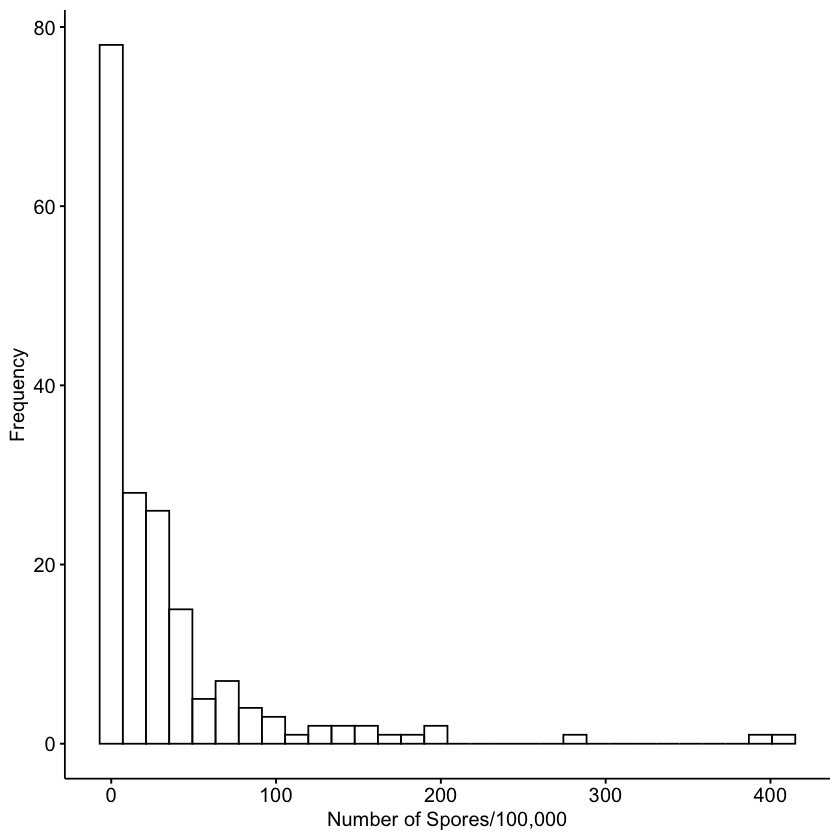

In [37]:
# to choose the right model I need to see a distribution of the data
rnai.dist.hist <- gghistogram(rnai_spore_data, x = "divided_100000", y = "..count..", palette = 'npg', 
                         xlab = "Number of Spores/100,000", ylab = "Frequency", bins = 30)
rnai.dist.hist
# in this experiment the boxplots showed that some of the non-inocualted bees had spores, and not all the 
# inoculated bees did have spores.This means there is a level of pre-existing infection in the hives
# however, the 35 non-inoculted bees which showed spores are relatively evenly split between hives, so i 
# will keep them in any. like the diet supplementation experiment, I will run a prevalence model and then 
# run a spore load model on all the bees which had an infection

In [38]:
# the linear regression model to establish probability of getting a zero
rnai.prevalence1 <- glmer(susceptibility ~ infection + rnai + (1|hive), data = rnai_spore_data,
                              family = binomial)
summary(rnai.prevalence1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: susceptibility ~ infection + rnai + (1 | hive)
   Data: rnai_spore_data

     AIC      BIC   logLik deviance df.resid 
   218.4    234.4   -104.2    208.4      175 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5202 -0.7349  0.3968  0.7452  2.0994 

Random effects:
 Groups Name        Variance Std.Dev.
 hive   (Intercept) 0.1053   0.3245  
Number of obs: 180, groups:  hive, 3

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.9450     0.4348   4.473 7.71e-06 ***
infectionNon-Infected  -1.6858     0.3505  -4.810 1.51e-06 ***
rnaiScram              -1.5063     0.4319  -3.488 0.000488 ***
rnaiSucrose            -0.7789     0.4226  -1.843 0.065273 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) infN-I rnScrm
infctnNn-

In [39]:
# infection and RNAi interaction
rnai.prevalence2 <- glmer(susceptibility ~ infection*rnai + (1|hive), data = rnai_spore_data,
                         family = binomial)
summary(rnai.prevalence2)
# non-signifcant interaction effects and higher AIC - original model wins

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: susceptibility ~ infection * rnai + (1 | hive)
   Data: rnai_spore_data

     AIC      BIC   logLik deviance df.resid 
   222.0    244.3   -104.0    208.0      173 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4752 -0.7738  0.4040  0.7382  2.2887 

Random effects:
 Groups Name        Variance Std.Dev.
 hive   (Intercept) 0.1064   0.3262  
Number of obs: 180, groups:  hive, 3

Fixed effects:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         1.9101     0.5738   3.329 0.000872 ***
infectionNon-Infected              -1.6341     0.6573  -2.486 0.012917 *  
rnaiScram                          -1.3489     0.6628  -2.035 0.041818 *  
rnaiSucrose                        -0.8736     0.6823  -1.280 0.200382    
infectionNon-Infected:rnaiScram    -0.3450     0.8890  -0.388 0.697962    
infec

In [40]:
# without rnai
rnai.prevalence3 <- glmer(susceptibility ~ infection + (1|hive), data = rnai_spore_data,
                         family = binomial)
summary(rnai.prevalence3)
# higher AIC and RNAi effects were signif on original model. Original wins

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: susceptibility ~ infection + (1 | hive)
   Data: rnai_spore_data

     AIC      BIC   logLik deviance df.resid 
   227.6    237.2   -110.8    221.6      177 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9878 -0.7618  0.5031  0.6422  1.3945 

Random effects:
 Groups Name        Variance Std.Dev.
 hive   (Intercept) 0.08411  0.29    
Number of obs: 180, groups:  hive, 3

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.0897     0.2969   3.671 0.000242 ***
infectionNon-Infected  -1.5507     0.3296  -4.705 2.54e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
infctnNn-In -0.618

In [41]:
# without Hive random effect
rnai.prevalence4 <- glm(susceptibility ~ infection + rnai, data = rnai_spore_data,
                         family = binomial)
summary(rnai.prevalence4)
# AIC is lower here but by less than 1 so not sure whether to go with this model as the best fitting,
# however, it does use the least amount of parameters so this seems like the best choice objectively. But
# exploratory plots did show that there was differences between the level of infection between the hives


Call:
glm(formula = susceptibility ~ infection + rnai, family = binomial, 
    data = rnai_spore_data)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.9025     0.3853   4.938 7.89e-07 ***
infectionNon-Infected  -1.6484     0.3440  -4.792 1.65e-06 ***
rnaiScram              -1.4743     0.4258  -3.463 0.000535 ***
rnaiSucrose            -0.7622     0.4176  -1.825 0.067977 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 246.32  on 179  degrees of freedom
Residual deviance: 209.65  on 176  degrees of freedom
AIC: 217.65

Number of Fisher Scoring iterations: 4


In [42]:
# will run an anova to see if they are signifcantly different
anova(rnai.prevalence1, rnai.prevalence4)
# anova says they are not significantly different, so hive clearly doesnt explain a huge amount of the data
# in the model. I will keep the simpler GLM model and take hive out. 

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rnai.prevalence4,4,217.6542,230.4260,-104.8271,209.6542,NA,NA,NA
rnai.prevalence1,5,218.4127,234.3775,-104.2063,208.4127,1.241506,1,0.265181


### Summary from logistic regression
Through stepwise backward regression we found that a binomial GLM with only RNAi as a fixed factor better explained the presence of Nosema than a GLMM with hive as a random factor (X2 = 1.24, df = 1, p = 0.27). The model showed that non-Infected bees had were 80% less likely to show Nosema spores at the end of the experiment compared to Infected bees (Estimate = -1.65 (±0.34), z = -4.79, p < 0.001). Also bees without the Relish gene active were found to have a significantly higher chance of being Infected compared to scramble RNAi treatment (Estimate =-1.4743 (±0.4258), z = -3.463, p < 0.001), but not compared to sucrose treatment (Estimate = -0.7622 (±0.4176), z = -1.825, p = 0.06)

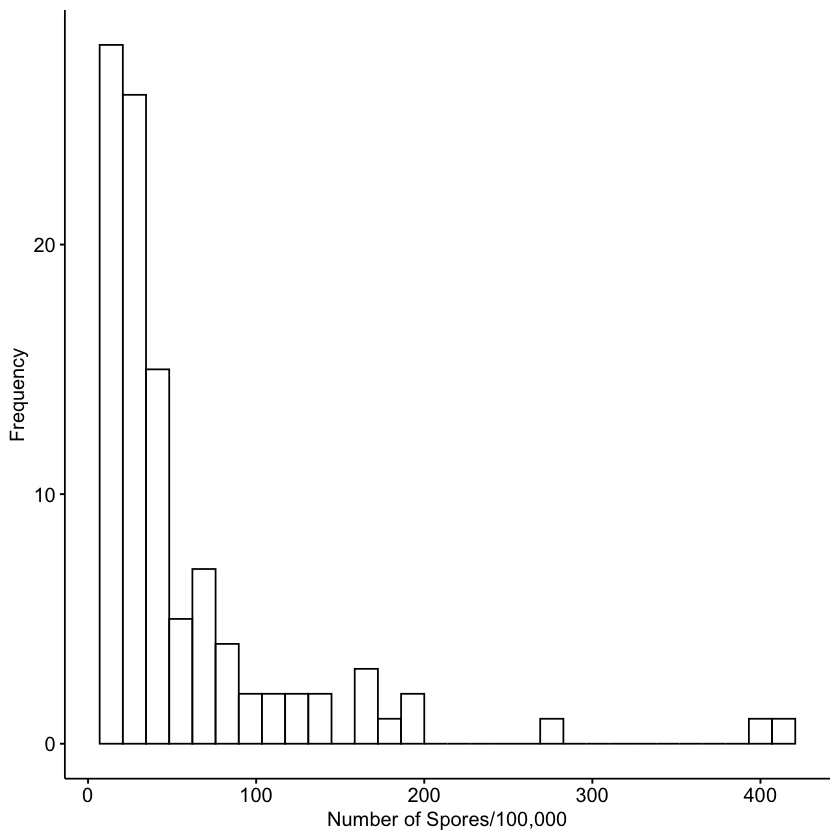

In [46]:
# spore analysis on all data, with non-inoculated spores too
# because some of the control 'non-inoculated' bees did turn out to have an infection, it must mean that
# they bought it from the hive. Whilst this isnt ideal, even the inoculated bees will have some level of 
# underlying infection so it shouldnt make too much difference. Just reference this in the results
# And as these bees are split relatively equally among hives I can keep them in with skewing the data. 
rnai_stripped <- rnai_spore_data %>% filter(divided_100000 !=0)
stripped.disthist <- gghistogram(rnai_stripped, x = "divided_100000", y = "..count..", palette = 'npg',  bins = 30) + 
  xlab("Number of Spores/100,000") + ylab("Frequency")
stripped.disthist

In [56]:
global.rnai.stripped <- glmer.nb(divided_100000 ~ rnai + infection + (1|hive), data = rnai_stripped)
summary(global.rnai.stripped)
# Non-infected bees did have significantly reduced number of spores, which is perhaps what we would expect
# given that they had at least 200,000 less spores than any of the inoculated bees. Sucrose still had significantly
# higher numbers of spores. The sucrose treatment had working Relish gene, so higher spores here suggests that 
# Relish is not important in reducing spore levels. 

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(1.7381)  ( log )
Formula: divided_100000 ~ rnai + infection + (1 | hive)
   Data: rnai_stripped

     AIC      BIC   logLik deviance df.resid 
  1005.3   1021.1   -496.7    993.3       96 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1703 -0.7590 -0.2502  0.3558  4.5224 

Random effects:
 Groups Name        Variance Std.Dev.
 hive   (Intercept) 0.08526  0.292   
Number of obs: 102, groups:  hive, 3

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            4.02154    0.21778  18.466  < 2e-16 ***
rnaiScram              0.02918    0.19840   0.147   0.8831    
rnaiSucrose            0.42281    0.17993   2.350   0.0188 *  
infectionNon-Infected -0.86738    0.16622  -5.218 1.81e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) rnScrm rnS

In [49]:
rnai.stripped.nohive <- glm.nb(divided_100000 ~ rnai + infection, data = rnai_stripped)
summary(rnai.stripped.nohive)
# will run a model without have as a random effect
# Higher AIC than the original model, suggesting the model is a better fit when hive is included as a random factor


Call:
glm.nb(formula = divided_100000 ~ rnai + infection, data = rnai_stripped, 
    init.theta = 1.549811391, link = log)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            4.11140    0.14163  29.028  < 2e-16 ***
rnaiScram             -0.03538    0.20741  -0.171   0.8646    
rnaiSucrose            0.45041    0.18731   2.405   0.0162 *  
infectionNon-Infected -0.89417    0.17259  -5.181 2.21e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5498) family taken to be 1)

    Null deviance: 144.95  on 101  degrees of freedom
Residual deviance: 110.94  on  98  degrees of freedom
AIC: 1011.3

Number of Fisher Scoring iterations: 1


              Theta:  1.550 
          Std. Err.:  0.205 

 2 x log-likelihood:  -1001.330 

In [50]:
# wil run a final model with no RNAi as a factor
rnai.stripped.nornai <- glmer.nb(divided_100000 ~ infection + (1|hive), data = rnai_stripped)
summary(rnai.stripped.nornai)
# without RNAi, the model has a higher AIC than the global model 

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(1.6455)  ( log )
Formula: divided_100000 ~ infection + (1 | hive)
   Data: rnai_stripped

     AIC      BIC   logLik deviance df.resid 
  1007.7   1018.2   -499.9    999.7       98 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1620 -0.7370 -0.2201  0.3506  4.3175 

Random effects:
 Groups Name        Variance Std.Dev.
 hive   (Intercept) 0.09436  0.3072  
Number of obs: 102, groups:  hive, 3

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             4.1859     0.2034  20.577  < 2e-16 ***
infectionNon-Infected  -0.8747     0.1697  -5.156 2.53e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
infctnNn-In -0.291

In [51]:
# will run some anovas to see if the models are definitely different
anova(global.rnai.stripped, rnai.stripped.nohive)
# shows the global model is significantly better at explaining data than the no-hive model

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rnai.stripped.nohive,5,1011.330,1024.455,-500.6649,1001.3298,NA,NA,NA
global.rnai.stripped,6,1005.346,1021.096,-496.6730,993.3461,7.983667,1,0.004720124


In [55]:
Anova(global.rnai.stripped)
# model is significantly better at explaining data than the null model

Warning message in printHypothesis(L, rhs, names(b)):
“one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted”


,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
rnai,6.305355,2,4.273753e-02
infection,27.229911,1,1.806423e-07


## 3. Plotting our findings
We have shown that in treatments where the Relish gene was silenced, bees were significantly more likely to have an infection compared to those treated with Scramble RNAi, but not more likely than those fed only sucrose (GLM binomial: Estimate = 1.47 ± 0.43, z = 3.46, P < 0.001 and Estimate = 0.76 ± 0.42, z = 1.83, P = 0.068, respectively. Regarding spore intensity, inoculated bees had significantly higher spore loads than non-inoculated bees (n = 102, GLMM negative binomial: Estimate = -0.87 ± 1.67, z = -5.22,P < 0.001). Bees fed only sucrose had a significantly higher number of spores than those fed Relish RNAi (Estimate = 0.42 ± 0.18, z = 2.35, P = 0.019), although there was no difference between Relish RNAi and Scramble RNAi treatments (Estimate = 0.03 ± 0.20, z = 0.15, P = 0.883). Spore load was found to vary significantly between hives (χ 2 = 7.38, d.f. = 1, P = 0.005), suggesting hives responded differently to Nosema spp. infection.

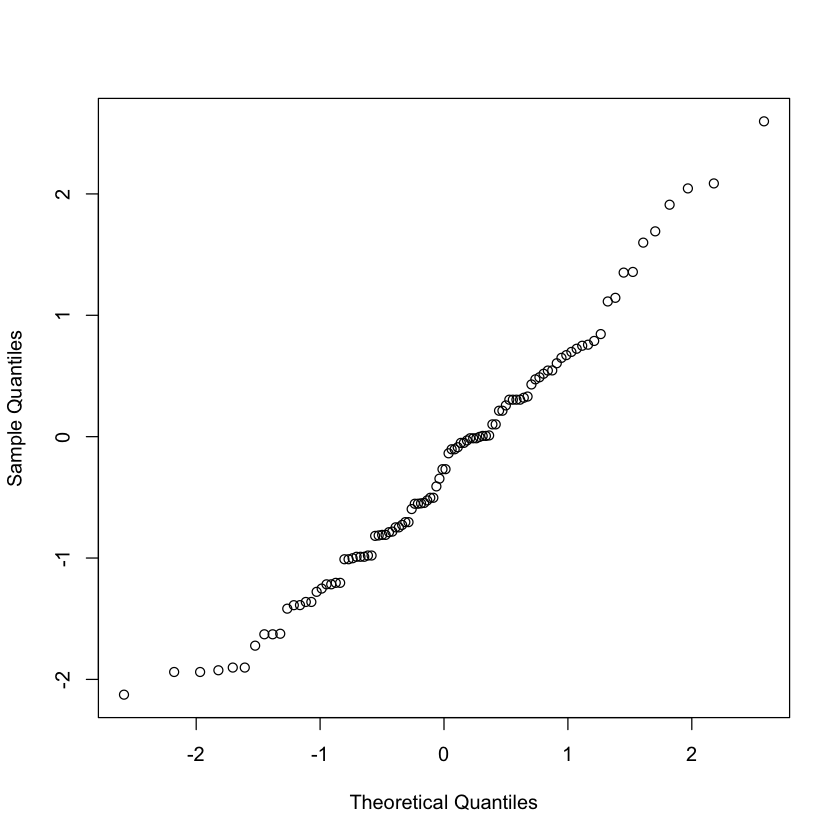

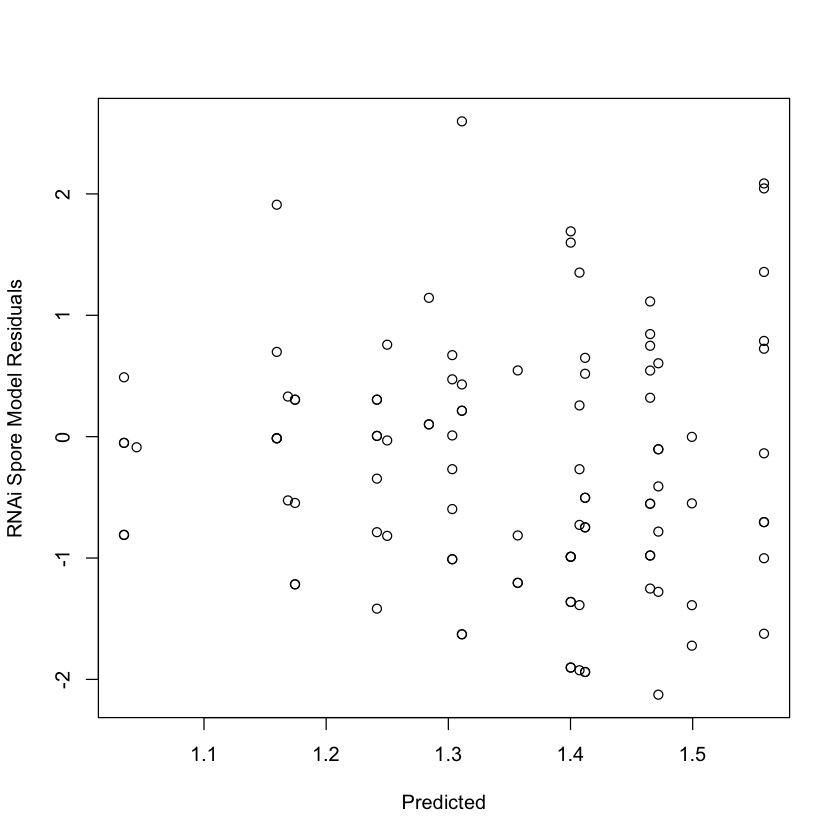

In [57]:
# create residual and qqnorm plots
rnai.validation.global <- residuals(global.rnai.stripped, type="deviance")
qqnorm(rnai.validation.global, main = "")
plot(log(predict(global.rnai.stripped)), rnai.validation.global, ylab = "RNAi Spore Model Residuals", xlab = "Predicted")

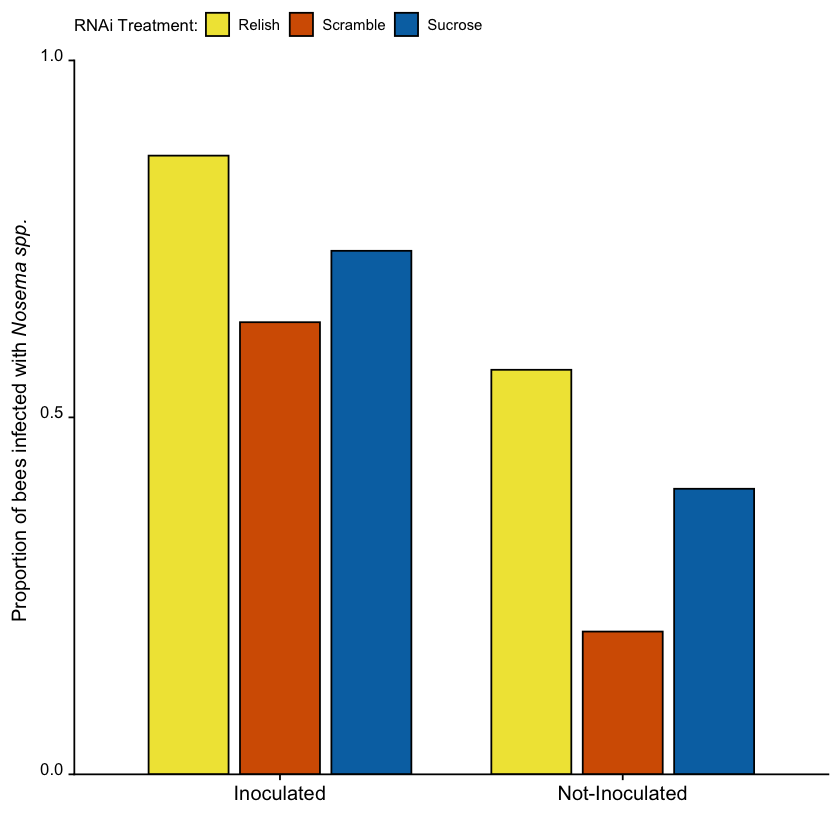

In [58]:
# susceptibility
rnai.susceptibility.barchart <-  ggplot(rnai_spore_data, aes(x = infection, y = susceptibility/30, fill = rnai)) + 
  stat_summary(fun=sum,geom="bar",colour="black", width = 0.7, position = position_dodge(width = 0.8)) + 
  scale_fill_manual(values =  c("#F0E442", "#D55E00","#0072B2"), labels = c("Relish", "Scramble", "Sucrose")) + 
  theme_cowplot() + ylab("Proportion of bees infected with"~italic("Nosema spp.")~"") + xlab("") + 
  scale_x_discrete(labels = c("Inoculated", "Not-Inoculated")) + 
  theme(axis.text.x = element_text(face = "plain",size = 12,vjust = 0.99, hjust = 0.5, colour = "black"), axis.text.y = element_text(face="plain", size = 10, angle = 0, vjust = 0.0,  hjust = 0.5, colour = "black")) + 
  theme(text = element_text(size=12)) + scale_y_continuous(limits = c(0,1), expand = c(0,0), breaks = seq(0,1, by = 0.5)) + 
  guides(fill=guide_legend(title="RNAi Treatment:")) + theme(legend.text=element_text(size=9), legend.title=element_text(size=10), legend.position = "top")
rnai.susceptibility.barchart

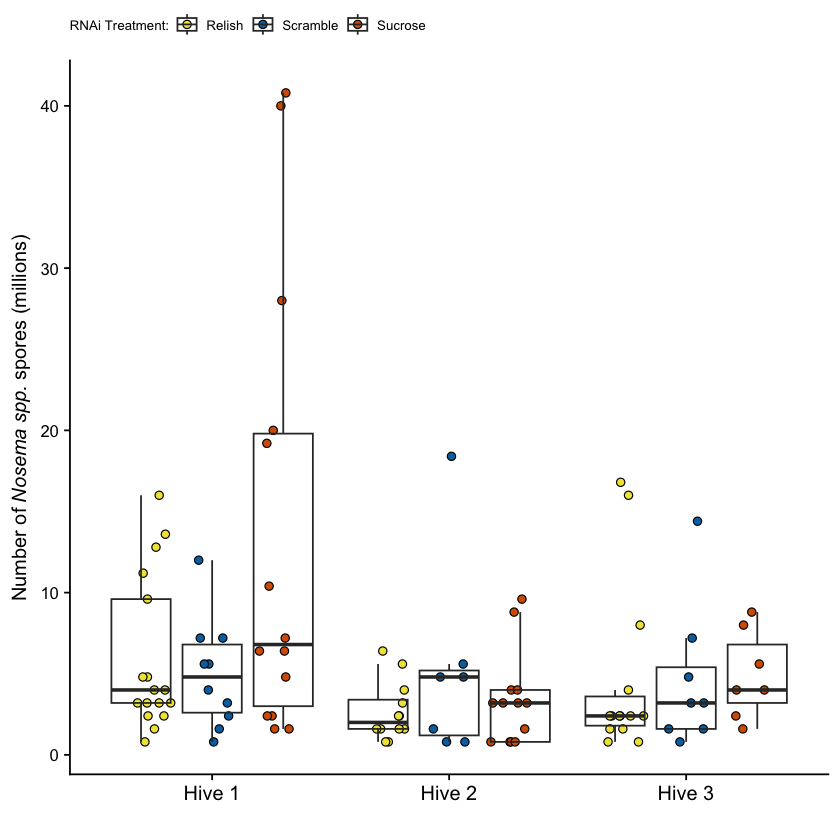

In [59]:
# plotting boxplot for spores
s <- ggplot(rnai_stripped, aes(x=hive, y=spores/1000000, fill=rnai))
rnai.stripped.boxplot <- s + geom_point(aes(fill = rnai), size = 2, shape = 21, position = position_jitterdodge()) + 
  geom_boxplot(position = position_dodge(0.9), alpha = 0) + theme_cowplot() + 
  theme(legend.position = "top") + ylab("Number of"~italic("Nosema spp.")~"spores (millions)") + scale_x_discrete(labels = c("Hive 1", "Hive 2", "Hive 3")) + 
  theme(legend.text=element_text(size=8), legend.title=element_text(size=8)) + guides(fill=guide_legend(title="RNAi Treatment:")) + 
  xlab("") + theme(text = element_text(size=12), axis.text.y = element_text(size = 10)) + 
  scale_fill_manual(values=c("#F0E442", "#0072B2", "#D55E00"), labels = c("Relish", "Scramble", "Sucrose"))
rnai.stripped.boxplot